In [8]:
# coding=utf-8
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas, geoplot, random, re, scipy
from bs4 import BeautifulSoup as BS
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure, savefig
from sklearn.decomposition import PCA

# Predefined variables

In [3]:
font = {'size': 16}
matplotlib.rc('font', **font)

rankings = ['THE', 'QS', 'CWUR', 'ARWU']
countries = {
    'AG': 'Argentina', 'AU': 'Austria', 'AUS': 'Australia', 'BE': 'Belgium', 'BEL': 'Belarus', 'BZ': 'Brazil',
    'CA': 'Canada', 'CH': 'China', 'CHI': 'Chile', 'COL': 'Colombia', 'CZ': 'Czech', 'DN': 'Denmark',
    'EG': 'Egypt', 'ES': 'Estonia', 'FI': 'Finland', 'FR': 'France', 'GE': 'Germany', 'GR': 'Greece',
    'IN': 'India', 'ID': 'Indonesia', 'IR': 'Ireland', 'IRN': 'Iran', 'IT': 'Italy', 'IS': 'Izrael',
    'JP': 'Japan', 'KO': 'Korea', 'KZ': 'Kazakhstan', 'LE': 'Lebanon', 'MA': 'Malaysia', 'ME': 'Mexico',
    'NE': 'Netherlands', 'NO': 'Norway', 'NZ': 'New Zealand', 'PH': 'Philippines', 'PAK': 'Pakistan',
    'POL': 'Poland', 'POR': 'Portugal', 'RU': 'Russia', 'SA': 'South Africa', 'SAU': 'Saudi Arabia',
    'SG': 'Singapore', 'SP': 'Spain', 'SW': 'Sweden', 'TH': 'Thailand', 'UA': 'Ukraine',
    'UAE': 'United Arab Emirates', 'UK': 'United Kingdom', 'US': 'United States of America'
}

media_dir = 'Media/'
EDA_dir = 'Media/EDA/'
rankings_dir = 'Media/Rankings'

inputs_all = list(map(str, list(range(1, 57))))
inputs_all.remove('47')

edu = list(map(str, list(range(1, 10))))
science = list(map(str, list(range(10, 21))))
staff = list(map(str, list(range(21, 30))))
inter = list(map(str, list(range(30, 39))))
infra = list(map(str, list(range(39, 47))))
fin = list(map(str, list(range(48, 57))))


inputs = ['1.1', '1', '9', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.16', '13', '14', '3.1', '3.2', 
          '3.8', '3.9', '35', '4.1', '4.3', '48', '5.1', '5.6', '40', '41', '42', '46', '6.1', '6.2', '6.4', '28',
         '2.1_2_3', '2.4_5_6', '3.1_2', '6.1_2', '13_14', '40_41_42']
inputs_grouped = ['1.1', '1', '9', '2.7', '2.16', '3.8', '3.9', '35', '4.1', '4.3', '48',
            '5.1', '5.6', '46', '6.4', '28', '2.1_2_3', '2.4_5_6', '3.1_2', '6.1_2', '13_14', '40_41_42']
outputs = ['E.1', 'E.2', 'E.3', 'E.4', 'E.5']

# User defined functions

In [4]:
def set_rank(rank_range):
    """
    Set university rank if it is defined as range, but not a single value
    
    Parameters:
    rank_range (str): Consists university rank. Two formats: "a-b" or "c+", where a, b, c are integers and a < b
    
    Return
    int: University rank as an integer
    """
    
    range_min_max = re.search('(\d+)?-?(\d+)?\+?', rank_range)

    if range_min_max[2] is None:
        return int(range_min_max[1])
    else:
        rank = random.randint( int(range_min_max[1]), int(range_min_max[2]) )
        return int(rank)

In [5]:
def kendall_w(data):
    """
    Calculate and return Kendall's coefficient of concordance
    
    Parameters
    data (Pandas dataframe): Dataframe of data
    
    Return
    int: W coefficient
    """
    
    m = 4
    n = len(data)

    Ri = data.sum(axis = 1)
#     Rm = np.sum(Ri) / n
    
    T = 0
    for ranking in data:
        vc = data[ranking].value_counts()
        d = vc[vc > 1]
        t = np.sum(list(map(lambda t: t ** 3 - t, d)))
        T = T + t
    
    W = (12 * np.sum(Ri) - 3 * m ** 2 * n * (n + 1) ** 2) / (m ** 2 * n * (n ** 2 - 1) - m * T)
#     S = np.sum( (Ri - Rm) ** 2 )
#     W = (12 * S) / ((m ** 2) * (n ** 3 - n) - 3 * (n + 1) / (n - 1))
    
    rS = (m * W - 1) / (m - 1)

    return (T, W, rS)

# Web scrapers

### Parse all Russian universities

In [12]:
url = 'http://indicators.miccedu.ru/monitoring/index.php?m=vpo'
r = requests.get(url)
r.encoding = r.apparent_encoding
page = BS(r.text, 'html.parser')

columns = []
uni_id_list = []
uni = []
data = pd.DataFrame(data = [[0, 1, 2, 3, 4]],
                    columns = ['uni_id', 'index', 'desc', 'dim', 'measure'])

for state in page.select('p.MsoListParagraph a[href]'): # through regions
    region_url = host + str(year) + '/' + state['href']
    r = requests.get(region_url)
    r.encoding = r.apparent_encoding
    state_page = BS(r.content)
    
    for uni in state_page.select('.blockcontent tr td.inst a[href]'): # through unis
        uni_id = int(uni['href'][12:])
        uni.append(uni.get_text())
        uni_id_list.append(uni_id)
        uni_url = host + '_vpo/' + uni['href']
        r = requests.get(uni_url)
        r.encoding = r.apparent_encoding
        uni_page = BS(r.content)
                    
        for indicator in uni_page.select('table#analis_dop tr'): # through the last table
            fields = []
            td_num = len(indicator.find_all('td'))
            
            if td_num == 4: # skip headings and not full rows
                for td in indicator.select('td'):
                    fields.append(td.get_text())
                row = pd.DataFrame(data = [[uni_id, fields[0], fields[1], fields[2], fields[3]]],
                                    columns = ['uni_id', 'index', 'desc', 'dim', 'measure'])
                data = data.append(row)

data = data.iloc[3:, :]
data.set_index('uni_id', inplace = True)
data.to_excel('russian_uni.xlsx', index = False)

### Parse Desired Russian Universities

In [139]:
url = 'http://indicators.miccedu.ru/monitoring/_vpo/inst.php?id='
unis = pd.read_excel('Data/Russian_Universities_Initial.xlsx')

for index, uni in unis.iterrows():
    r = requests.get(url + str(uni.Uni_Id))
    r.encoding = r.apparent_encoding
    page = BS(r.text, 'html.parser')
    
    
    for indicator in page.select('table#analis_dop tr'): # through the last table
        fields = []
        td_num = len(indicator.find_all('td'))
            
        if td_num == 4: # skip headings and not full rows
            not_valid = False
            for ix, td in enumerate(indicator.select('td')):
                if re.search('№', td.get_text()) or (ix == 2 and re.search('да', td.get_text())):
                    not_valid = True
                    break
                else:
                    fields.append(td.get_text())
            
            if not_valid == False:
                unis.loc[index, str(fields[0])] = float(fields[3].replace(' ', '').replace(',', '.'))

    for table in page.select('table.napde'):        
        row = []
        for ix, indicator in enumerate(table.select('td')): # through the last table
            if ix in [0, 1, 2, 3]:
                continue
            else:
                res = divmod(ix, 4)
                if res[1] in [0, 3]:
                    row.append(indicator.get_text())
                    
                if res[1] == 3:
                    unis.loc[index, str(row[0])] = float(row[1].replace(' ', '').replace(',', '.'))
                    row = []

    # working with outpus
    # there is an additional empty tbody before thead of the result table, so we cannot use BS
    # use regex instead
    Es = re.findall('(E\.\d)</td>', str(page))
    output_values = re.findall('right center no-repeat;\">(\d+(?:,\d+)?)<', str(page))
    income = re.findall('<span style=\"\">(\d+(?:,\d+)?)<', str(page))
    output_values.insert(4, income[0])
    
    for ix, val in enumerate(output_values):
        unis.loc[index, Es[ix]] = float(val.replace(',', '.'))
        
        
unis['2.1_2_3'] = unis['2.1'] + unis['2.2'] + unis['2.3']
unis['2.4_5_6'] = unis['2.4'] + unis['2.5'] + unis['2.6']
unis['3.1_2'] = unis['3.1'] + unis['3.2']
unis['6.1_2'] = unis['6.1'] + unis['6.2']
unis['13_14'] = unis['13'] + unis['14']
unis['40_41_42'] = (unis['40'] + unis['41'] + unis['42']) / 10000

### Set university ranks

In [140]:
for index, university in unis.iterrows():
    for ranking in ['THE', 'QS', 'CWUR', 'ARWU']:
        value = unis.loc[unis.University == university[0], ranking]
        if not (isinstance(value[index], int) or value[index] is None or isinstance( value[index], float)):
            unis.loc[unis.University == university[0], ranking] = set_rank(value[index])
            
unis.to_excel('Data/Russian_Universities.xlsx', index = False)
unis.to_csv('Data/Russian_Universities.csv', index = False)

### Set university ranks for rankings time series

In [129]:
unis = pd.read_excel('Data/Russian_Universities.xlsx')
data = pd.read_excel('Data/Russian_Universities_TS_Initial.xlsx')
data.loc[(data.Year == 2020) & (data.Ranking == 'THE')].Rank = unis.THE
data.loc[(data.Year == 2020) & (data.Ranking == 'QS')].Rank = unis.QS
data.loc[(data.Year == 2020) & (data.Ranking == 'ARWU')].Rank = unis.ARWU
data.loc[(data.Year == 2020) & (data.Ranking == 'CWUR')].Rank = unis.CWUR

for index, row in data.iterrows():
    rank = row[2] # rank
    if not isinstance(rank, int) and not (rank is None) and not isinstance( rank, float):
        data.loc[index, 'Rank'] = set_rank(rank)

data.to_excel('Data/Russian_Universities_TS.xlsx', index = False)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Parse Shanghai Ranking

In [138]:
url = 'http://www.shanghairanking.com/ARWU2019.html'
r = requests.get(url)
page = BS(r.text, 'html.parser')

data = pd.DataFrame(data = [[0, 1, 2, 3, 4, 5, 6, 7]],
                    columns = ['Rank', 'Uni', 'Alumni', 'Award', 'HiCi', 'N&S', 'PUB', 'PCP'])

for i, uni in enumerate(page.select('table#UniversityRanking tr')):
    if i == 0:
        continue
    else:
        fields = []
        for j, indicator in enumerate(uni.select('td')):
            if j in [0, 1, 5, 6, 7, 8, 9, 10]:
                if j == 1:
                    ind = (indicator.select('a'))[0].text
                else:
                    ind = indicator.text
                fields.append(ind)
        row = pd.DataFrame(data = [[fields[0], fields[1], fields[2], fields[3], fields[4], fields[5], fields[6], fields[7]]],
                                    columns = ['Rank', 'Uni', 'Alumni', 'Award', 'HiCi', 'N&S', 'PUB', 'PCP'])
        data = data.append(row)

data.set_index('Rank', inplace = True)
data.to_excel('Data/ARWU_Ranking_Full.xlsx')

# Rankings

In [13]:
world = (pd.read_excel('Data/All_Universities_2020.xlsx')).iloc[:500, :29]
uni = world.University
world = world.set_index('University')
world = world.dropna()

world['Country'] = [countries[code] for code in world.loc[:, 'Country Code']]

# Fill ranged ranks (101-150, 800-1000)
for ranking in rankings:
    for rank_i in range(len(world[ranking])):
        rank = world[ranking][rank_i]
        if isinstance(rank, str):
            world.loc[:, ranking][rank_i] = set_rank(rank)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
# Convert to ranks
rdata = (world.reset_index())[rankings].rank(axis = 0, ascending = True)
rdata['University'] = uni
rdata = rdata.set_index('University')

world.THE = rdata.THE
world.QS = rdata.QS
world.CWUR = rdata.CWUR
world.ARWU = rdata.ARWU
rdata.head()

In [ ]:
print(kendall_w(rdata))

In [ ]:
# vc = rdata.QS.value_counts()
# sm = vc[vc > 1]

print(np.sum(list(map(lambda t: t ** 3 - t, [2, 3, 2, 3]))))

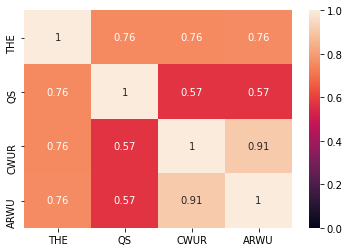

In [33]:
# All data
corr_matrix = scipy.stats.spearmanr(world.loc[:, rankings])[0]
sns.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True, xticklabels = rankings, yticklabels = rankings)
plt.savefig(media_dir + 'spearman_corr.png', bbox_inches='tight')

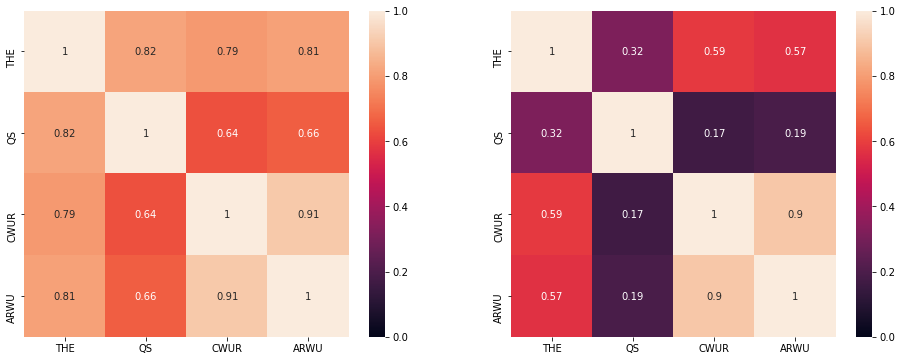

In [34]:
# 1-100 and 101-200
f, axes = plt.subplots(1, 2, figsize = (16, 6))
corr_matrix_100 = scipy.stats.spearmanr(world.loc[:, rankings][1:100])[0]
corr_matrix_200 = scipy.stats.spearmanr(world.loc[:, rankings][101:200])[0]

sns.heatmap(corr_matrix_100, vmin = 0, vmax = 1, annot = True, ax = axes[0], xticklabels = rankings, yticklabels = rankings)
sns.heatmap(corr_matrix_200, vmin = 0, vmax = 1, annot = True, ax = axes[1], xticklabels = rankings, yticklabels = rankings)
plt.savefig(media_dir + 'spearman_corr_1-100-200.png', bbox_inches='tight')

# Exploratory Data Analysis

In [15]:
rusuni = pd.read_excel('Data/Russian_Universities.xlsx')
rusuni.dropna(inplace = True)
rusuni.reset_index(drop = True, inplace = True)
rusuni = rusuni.loc[:, inputs + outputs + rankings + ['University', 'Region']]
rusuni.head()

,1.1,1,9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,...,E.2,E.3,E.4,E.5,THE,QS,CWUR,ARWU,University,Region
0,89.78,34838,1113,2064.72,2047.45,1577.35,85.12,95.16,143.13,8199628.1,...,979.35,7.50,3637.88,201.07,189.0,84.0,222.0,87.0,MSU,Moscow
1,97.52,6483,97,7135.52,7761.50,4917.96,217.13,247.86,334.41,3819955.2,...,4061.84,11.00,8767.60,244.94,237.0,302.0,539.0,473.0,MIPT,Moscow
2,95.76,28755,93,590.73,669.77,560.67,75.46,86.43,166.65,3718895.7,...,1461.66,9.56,8169.24,250.37,290.0,322.0,879.0,916.0,HSE,Moscow
3,92.28,5586,218,3203.41,3610.08,2046.36,279.07,348.53,273.33,2056242.8,...,3187.97,21.83,9751.86,282.76,482.0,329.0,726.0,643.0,MEPHI,Moscow
4,92.30,19277,2000,1484.47,1741.12,2178.31,84.13,99.73,174.48,2443650.9,...,603.40,13.87,4236.28,194.32,764.0,234.0,560.0,339.0,SPBU,StPetersburg


### Heatmaps

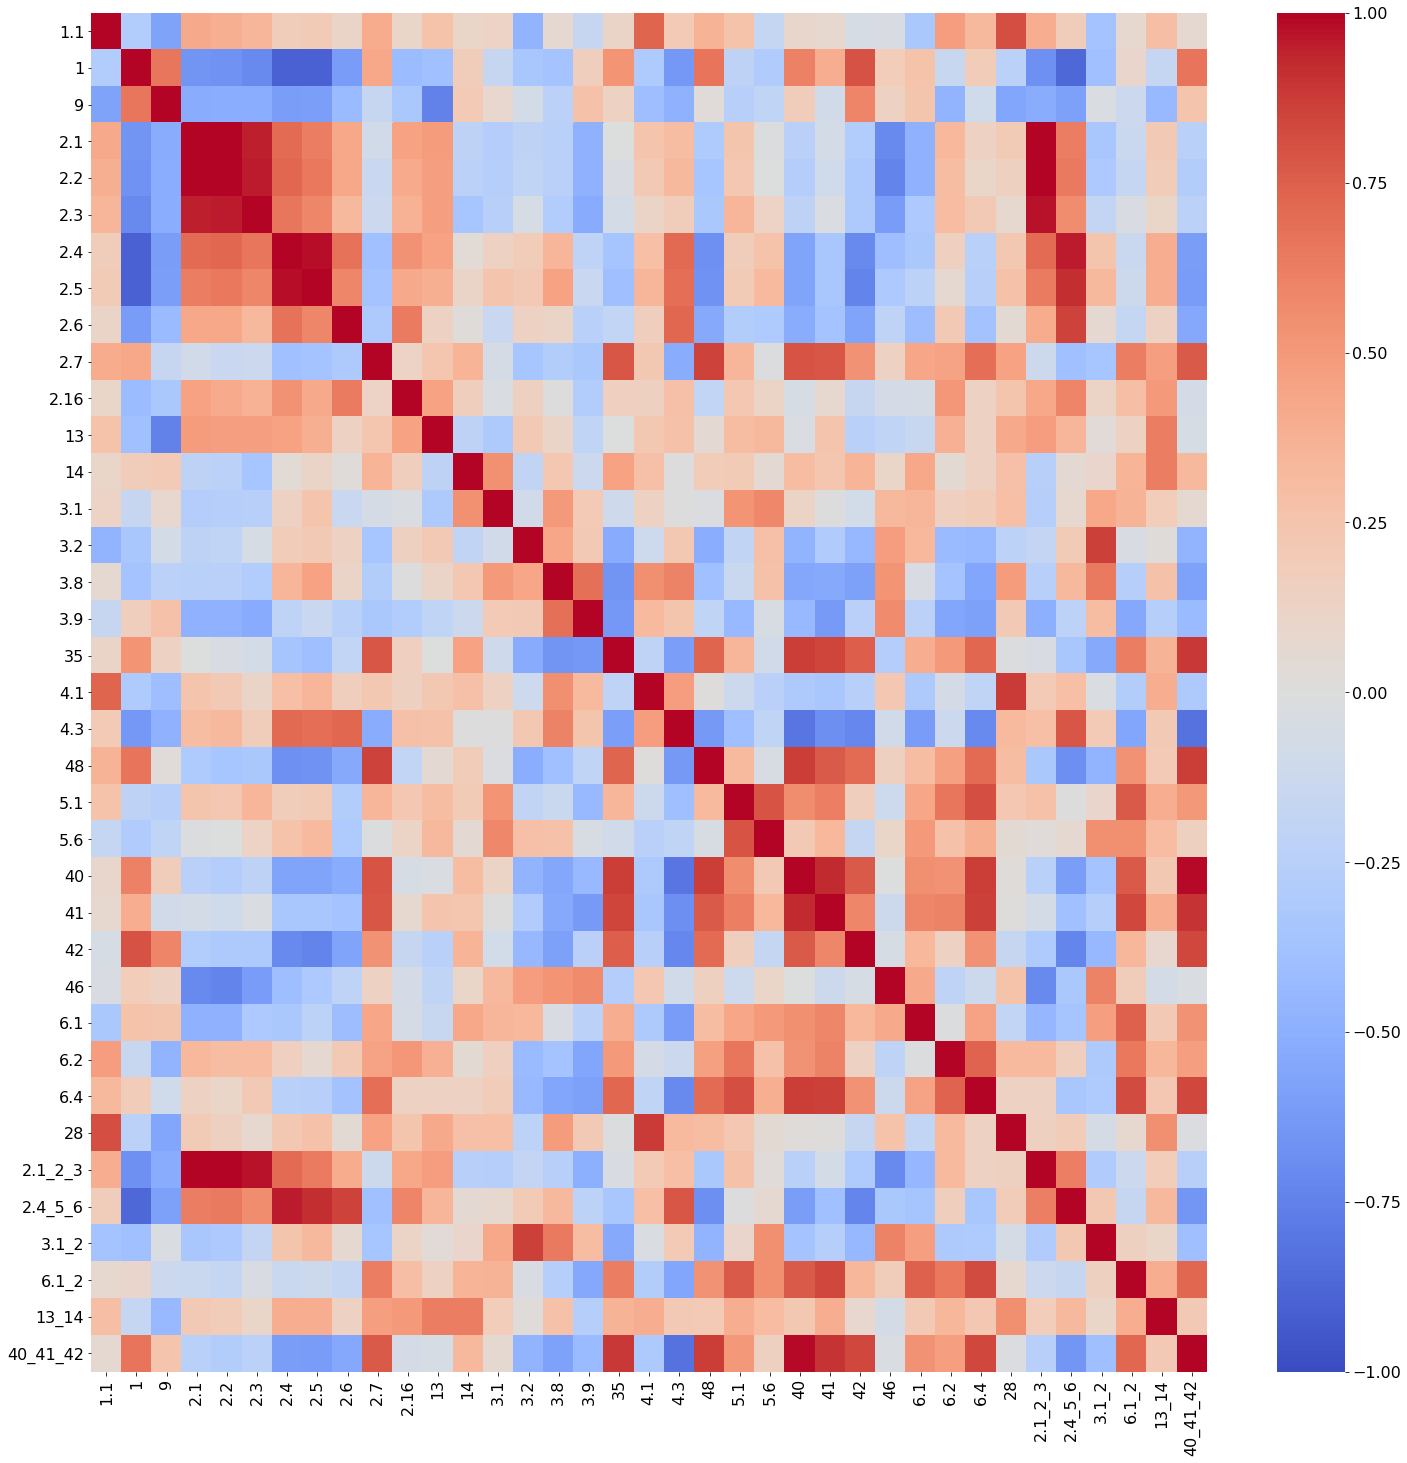

In [16]:
corr = rusuni.loc[:, inputs].corr()
figure(figsize = (25, 25))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_inputs.png', bbox_inches='tight')

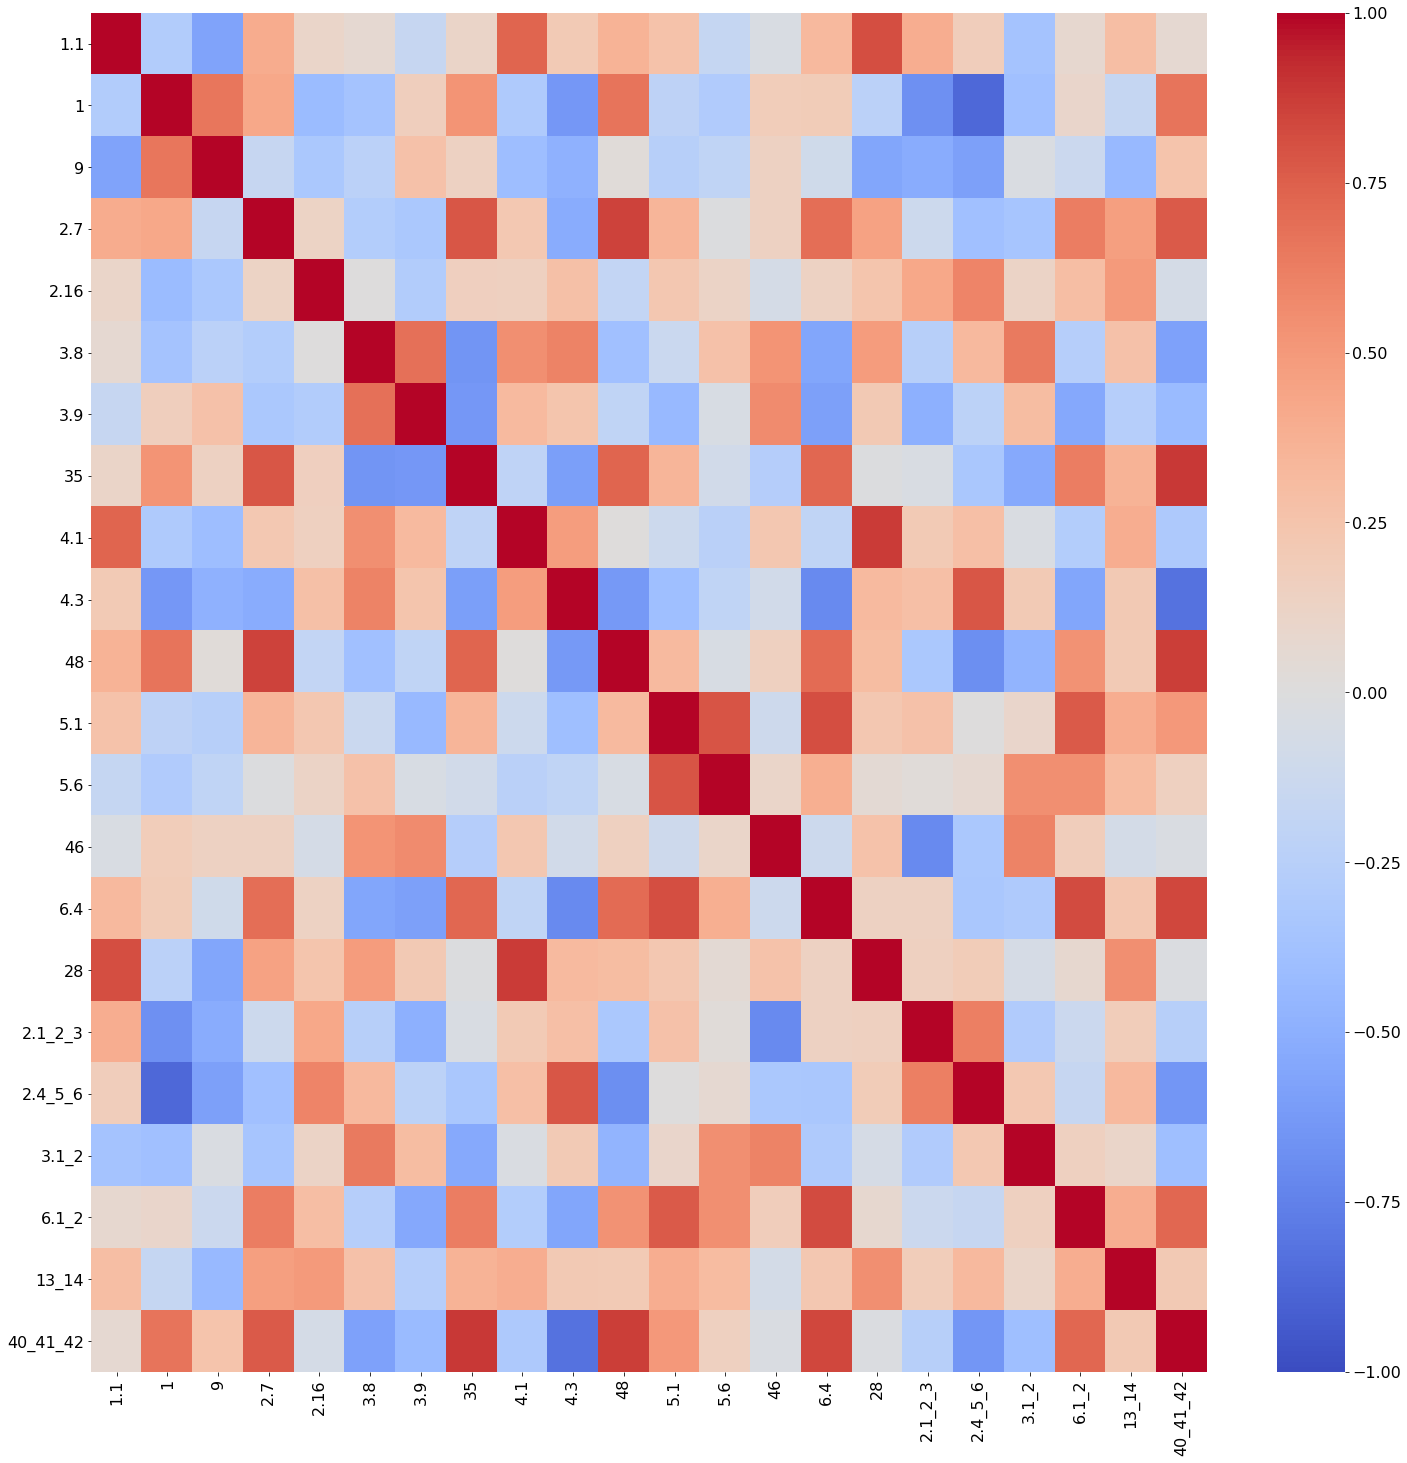

In [17]:
corr = rusuni.loc[:, inputs_grouped].corr()
figure(figsize = (25, 25))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_inputs_grouped.png', bbox_inches='tight')

Number of variables: 9


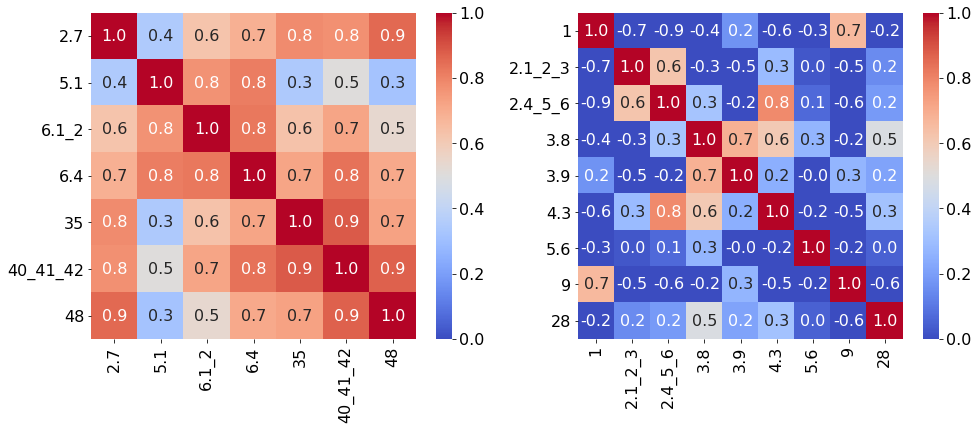

In [20]:
# Data exploration before PCA
f, axes = plt.subplots(1, 2, figsize = (16, 6))
positive_cor = ['2.7', '5.1', '6.1_2', '6.4', '35', '40_41_42', '48']
negative_cor = ['1', '2.1_2_3', '2.4_5_6', '3.8', '3.9', '4.3', '5.6', '9', '28']
output_cor_shrink = ['E.1', 'E.2', 'E.4', 'E.5']
output_cor = ['E.1', 'E.2', 'E.3', 'E.4', 'E.5']

corr_matrix_positive = rusuni.loc[:, positive_cor].corr()
corr_matrix_negative = rusuni.loc[:, negative_cor].corr()

sns.heatmap(corr_matrix_positive, vmin = 0, vmax = 1, annot = True, ax = axes[0], cmap = 'coolwarm', fmt=".1f")
sns.heatmap(corr_matrix_negative, vmin = 0, vmax = 1, annot = True, ax = axes[1], cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'spearman_corr_strong_weak.png', bbox_inches='tight')

print('Number of variables:', len(corr) - len(positive_cor) - len(negative_cor) + 3)

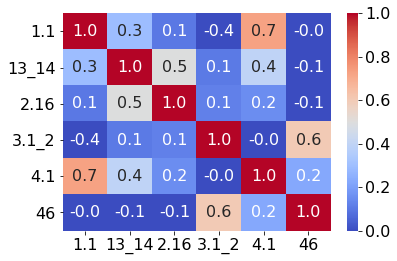

In [13]:
corr = ['1.1', '13_14', '2.16', '3.1_2', '4.1', '46']
corr_matrix = rusuni.loc[:, corr].corr()
sns.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True, cmap = 'coolwarm', fmt=".1f")

In [14]:
set(inputs_grouped) - set(positive_cor) - set(negative_cor)

{'1.1', '13_14', '2.16', '3.1_2', '4.1', '46'}

In [21]:
from sklearn.decomposition import PCA

pca_pos = PCA(n_components = 2)
pca_pos.fit(rusuni.loc[:, positive_cor].T)
PC1 = np.round(pca_pos.components_[0], 4)
# print('Explained variance ration positive: ', pca_pos.explained_variance_ratio_)
print('PC1 explained:', pca_pos.explained_variance_ratio_[0])


pca_neg = PCA(n_components = 2)
pca_neg.fit(rusuni.loc[:, negative_cor].T)
PC2 = np.round(pca_neg.components_[0], 4)
PC3 = np.round(pca_neg.components_[1], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC2, PC3 explained:', pca_neg.explained_variance_ratio_[0:2])


pca_out = PCA(n_components = 2)
pca_out.fit(rusuni.loc[:, output_cor].T)
PC4 = np.round(pca_out.components_[0], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC4 explained:', pca_out.explained_variance_ratio_[0])

pca_out = PCA(n_components = 2)
pca_out.fit(rusuni.loc[:, output_cor_shrink].T)
PC5 = np.round(pca_out.components_[0], 4)
# print('Explained variance ration negative: ', pca_neg.explained_variance_ratio_)
print('PC5 explained:', pca_out.explained_variance_ratio_[0])

rusuni.loc[:, 'INPUT1'] = PC1
rusuni.loc[:, 'INPUT2'] = PC2
rusuni.loc[:, 'INPUT3'] = PC3
rusuni.loc[:, 'OUTPUT_FULL'] = PC4
rusuni.loc[:, 'OUTPUT_SHRINK'] = PC5


rusuni.to_csv('Data/Russian_Universities.csv', index = False)

PC1 explained: 0.9942792352798083
PC2, PC3 explained: [0.84836963 0.14888786]
PC4 explained: 0.9861778886810342
PC5 explained: 0.9849453042637332


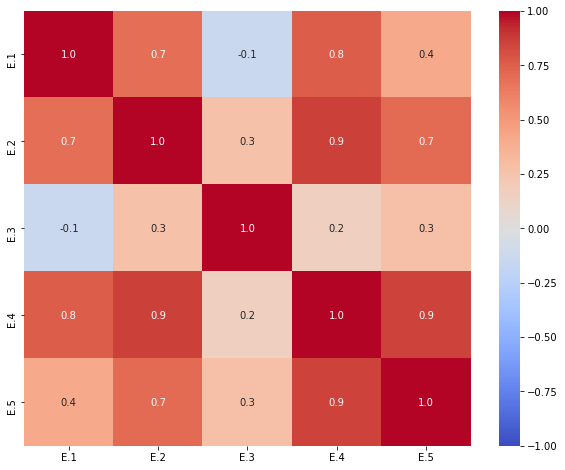

In [44]:
corr = rusuni.loc[:, outputs].corr()
figure(figsize = (10, 8))
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_outputs.png', bbox_inches='tight')

### Distribution plots

In [223]:
for input in inputs:
    figure(figsize = (20, 10))
    plt.plot(rusuni.University, rusuni[input])
    plt.title(input)
    plt.xticks(rotation = 90)
    plt.savefig(EDA_dir + 'Distributions/' + input + '.png', bbox_inches='tight')
    plt.close()

In [224]:
for output in outputs:
    figure(figsize = (20, 10))
    plt.plot(rusuni.University, rusuni[output])
    plt.title(output)
    plt.xticks(rotation=90)
    plt.savefig(EDA_dir + 'Distributions/' + output + '.png', bbox_inches='tight')
    plt.close()

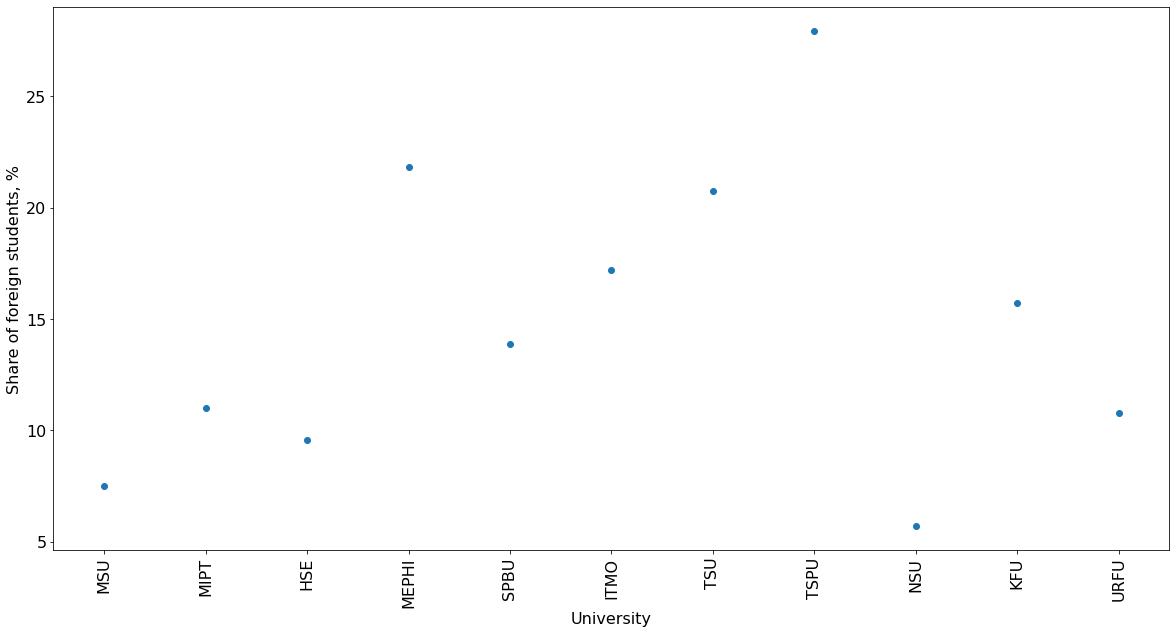

In [329]:
figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['3.1_2'], 'o')
plt.xlabel('University')
plt.ylabel('Share of foreign students, %')
plt.xticks(rotation = 90)
plt.savefig(EDA_dir + '/3-1_2_explained.png', bbox_inches='tight')

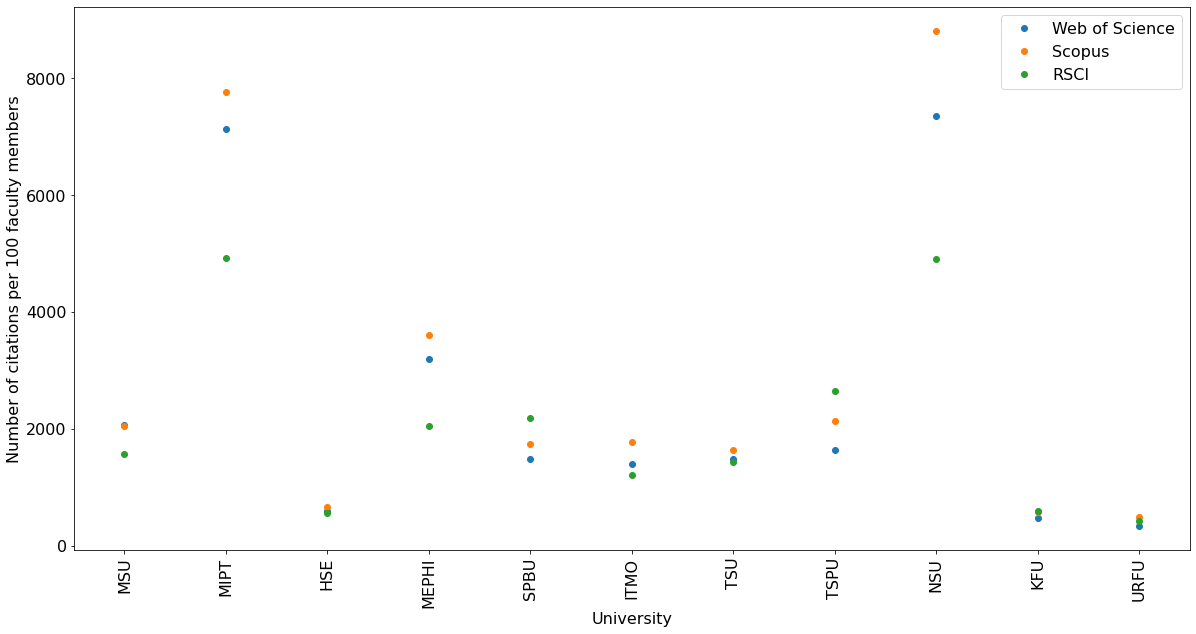

In [340]:
figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['2.1'], 'o')
plt.plot(rusuni.University, rusuni['2.2'], 'o')
plt.plot(rusuni.University, rusuni['2.3'], 'o')
plt.legend(['Web of Science', 'Scopus', 'RSCI'])
plt.xlabel('University')
plt.ylabel('Number of citations per 100 faculty members')
plt.xticks(rotation = 90)
plt.savefig(EDA_dir + '/2-1_2_3_explained.png', bbox_inches='tight')

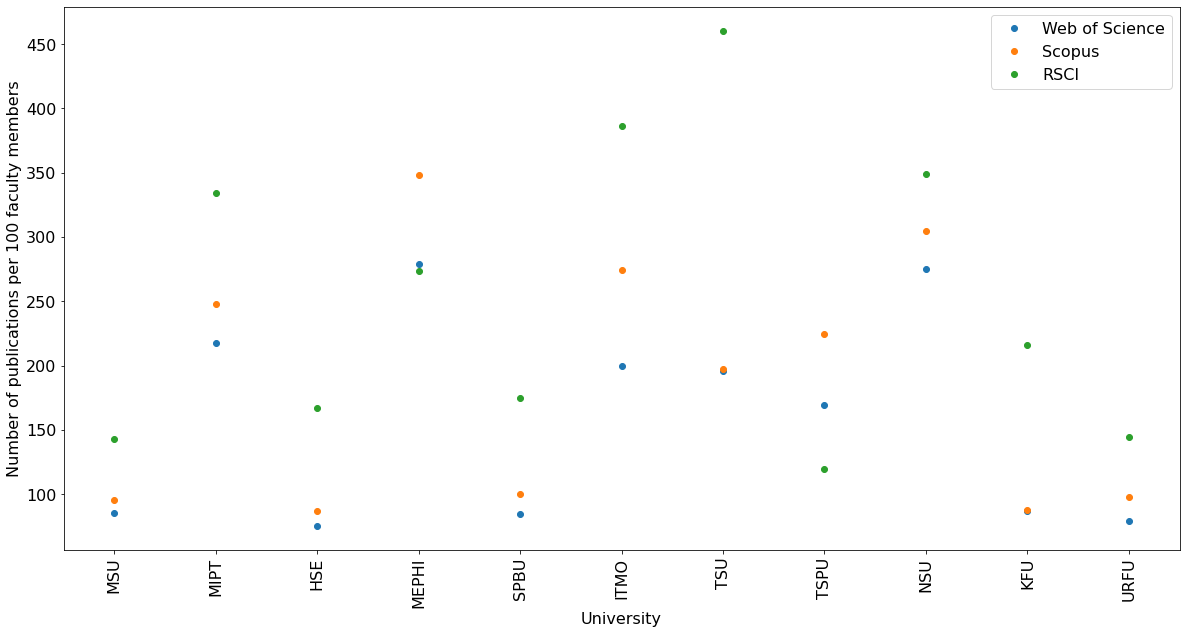

In [331]:
figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['2.4'], 'o')
plt.plot(rusuni.University, rusuni['2.5'], 'o')
plt.plot(rusuni.University, rusuni['2.6'], 'o')
plt.legend(['Web of Science', 'Scopus', 'RSCI'])
plt.xlabel('University')
plt.ylabel('Number of publications per 100 faculty members')
plt.xticks(rotation = 90)
plt.savefig(EDA_dir + '/2-4_5_6_explained.png', bbox_inches='tight')

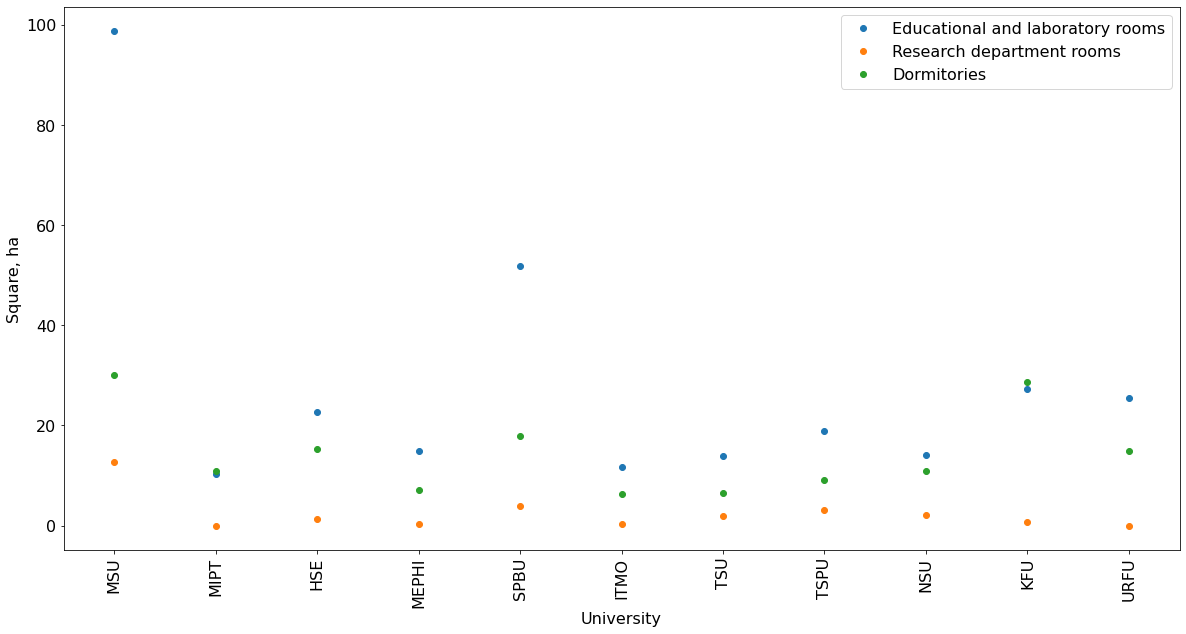

In [341]:
figure(figsize = (20, 10))
plt.plot(rusuni.University, rusuni['40'] / 10000, 'o')
plt.plot(rusuni.University, rusuni['41'] / 10000, 'o')
plt.plot(rusuni.University, rusuni['42'] / 10000, 'o')
plt.legend(['Educational and laboratory rooms', 'Research department rooms', 'Dormitories'])
plt.xlabel('University')
plt.ylabel('Square, ha')
plt.xticks(rotation = 90)
plt.savefig(EDA_dir + '/40_41_42_explained.png', bbox_inches='tight')

### Boxplots

In [317]:
for input in inputs:
    figure(figsize = (20, 10))
    sns.boxplot(rusuni[input])
    plt.title(input)
    plt.xticks(rotation = 90)
    plt.savefig(EDA_dir + 'BoxPlots/' + input + '.png', bbox_inches='tight')
    plt.close()

In [318]:
for output in outputs:
    figure(figsize = (20, 10))
    sns.boxplot(rusuni[output])
    plt.title(output)
    plt.xticks(rotation=90)
    plt.savefig(EDA_dir + '/BoxPlots/' + output + '.png', bbox_inches='tight')
    plt.close()

### Pairplots

In [ ]:
sns.pairplot(data.loc[:, inputs])

### Description

In [308]:
rusuni.groupby('Region').count().University
# rusuni.describe()

Region
Ekaterinburg    1
Kazan           1
Moscow          4
Novosibirsk     1
StPetersburg    2
Tomsk           2
Name: University, dtype: int64

### World universities on map

In [ ]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
boroughs = geopandas.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = geopandas.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

In [ ]:
world['unis_num'] = [0] * len(world)
world.head()

In [ ]:
geoplot.polyplot(world, figsize=(16, 12))

In [ ]:
world = world[(world.pop_est > 0) & (world.name != 'Antarctica')]

for country in world.name:
    if len(data.loc[data.Country == country, :]) > 0:
        world.loc[world.name == country, 'unis_num'] = uni_per_country[country]

world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world.plot(column='gdp_per_cap', figsize=(16, 12));

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(14)
fig.set_figwidth(16)
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='unis_num', legend = True, ax = ax, figsize=(16, 14), cmap = 'Reds', cax = cax);
plt.savefig('world.png')

### Universities time series

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


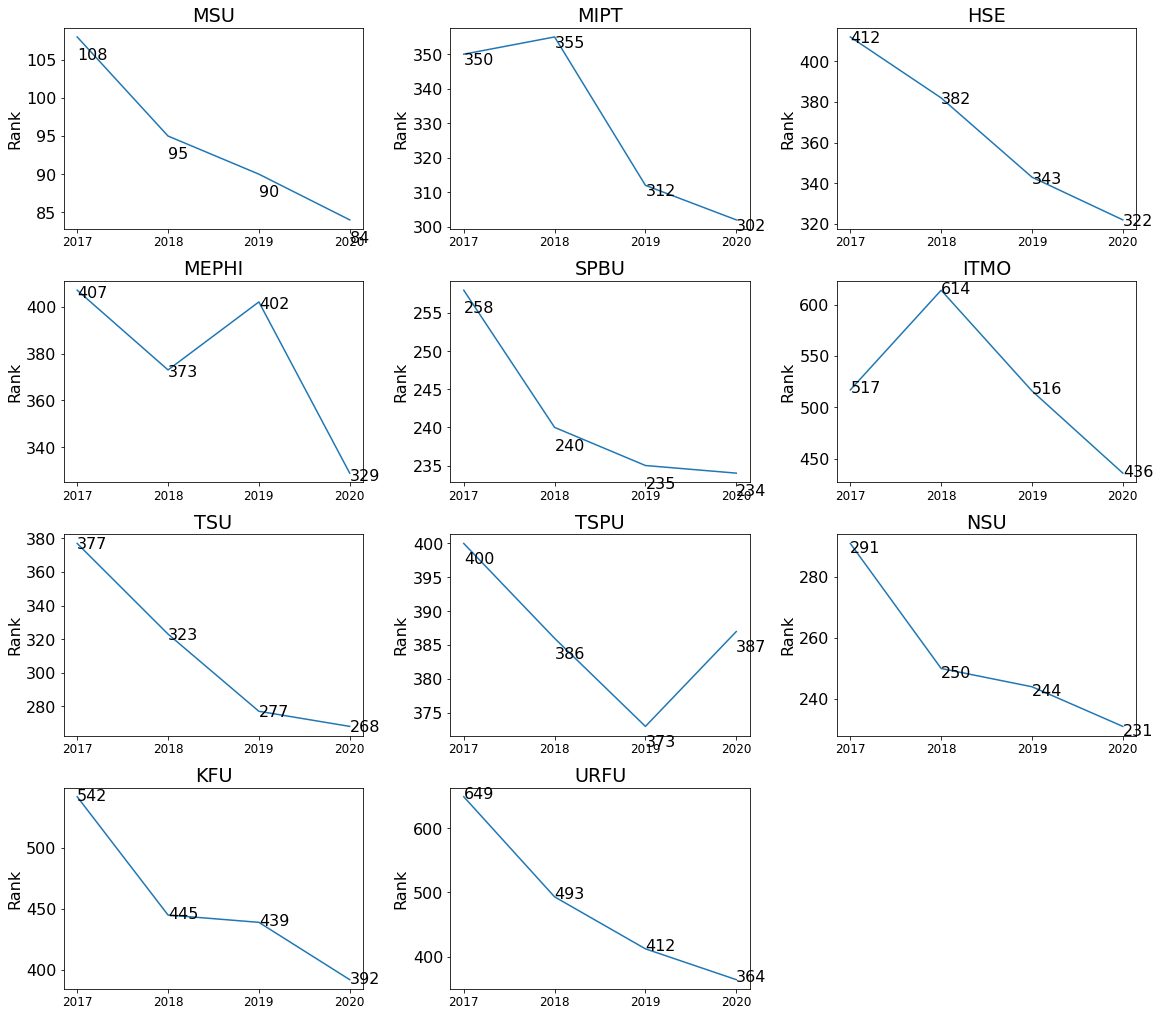

In [306]:
ts = pd.read_excel('Data/Russian_Universities_TS.xlsx')
QS = ts.loc[(ts.University.isin(rusuni.University)) & (ts.Ranking == 'QS')]
QS.dropna(inplace = True)

fig, axes = plt.subplots(4, 3,figsize = (16, 14), constrained_layout = True)

k = 0
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        if k < len(rusuni.University):
            uni_name = rusuni.University[k]
            u = QS.loc[QS.University == uni_name]
            u.reset_index(drop = True, inplace = True)
            axes[i, j].plot(u.Year, u.Rank)
            axes[i, j].set_xticks(u.Year)
            axes[i, j].set_xticklabels(u.Year, fontsize = 12)
            axes[i, j].set_title(uni_name)
            axes[i, j].set_ylabel('Rank')

            
            for ix, _ in enumerate(u.Year):
                axes[i, j].text(u.Year[ix], int(u.Rank[ix]) - 3, int(u.Rank[ix]))
        k = k + 1

axes[-1, -1].axis('off')
plt.savefig(media_dir + 'Russian_TS.png')